# Setup

In [ ]:
!pip install py-midicsv

import numpy as np
import pandas as pd
import py_midicsv as pm
import os
import tensorflow as tf
import csv
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from google.colab import drive
drive.mount('/content/drive/')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive/


In [ ]:
class Note:
  
  def __init__(self, length, start, pitch, velocity):

    self.length = length
    self.start = start
    self.pitch = pitch
    self.velocity = velocity

## Data Collection Functions

In [ ]:
def string_to_Note_s(csv_string):

  Notes = []

  num = (len(csv_string) - 4) / 2

  tempo = proper_split(csv_string[3])[-1]

  csv_string = csv_string[4:]

  other_notes = []

  counter = 0

  on = 0
  off = 0

  while counter < num:

    note = proper_split(csv_string[0])

    if note[2] == "Note_on_c":
      on += 1

      note = proper_split(csv_string[0])

      start = float(note[1])
      pitch = float(note[4])
      velocity = float(note[5])

      Notes.append(Note(0, start, pitch, velocity))

      del csv_string[0]

    elif note[2] == "Note_off_c":
      off += 1

      other_notes.append([float(note[1]), float(note[4]), float(note[5])])

      csv_string = csv_string[1:]

    real_num = len(Notes)

    counter += 1


  for i in range(real_num):

    counter = 0

    while len(other_notes) != 0 and len(Notes) != 0:

      if counter == len(other_notes):

        break

      if other_notes[counter][1] == Notes[i].pitch:

        Notes[i].length = float(other_notes[counter][0]) - float(Notes[i].start)

        del other_notes[counter]

        break

      counter += 1


  return Notes

In [ ]:
def proper_split(word):

  word = word.replace("\n", "")
  word = word.replace(" ", "")
  word = word.split(",")
  
  return word

In [ ]:
def dir_to_dict(dir):

  dict = {"name" : [], "time" : [], "gini" : [], "unq" : [], "avg_p" : [], "avg_r" : [], "avg_s" : [], "avg_l" : []}

  os.chdir(dir)

  list_dir = os.listdir(dir)

  for midi in list_dir:

    csv_string = pm.midi_to_csv(midi)

    Notes = string_to_Note_s(csv_string)

    temp = avg_r_unq(Notes)

    dict["name"].append(midi)

    dict["time"].append(time(Notes))

    dict["gini"].append(gini(Notes))

    dict["unq"].append(temp[1])

    dict["avg_p"].append(avg_p(Notes))

    dict["avg_r"].append(temp[0])

    dict["avg_s"].append(avg_s(Notes))

    dict["avg_l"].append(avg_l(Notes))

  return dict

In [ ]:
def time(Notes):

  return Notes[-1].start

In [ ]:
def avg_l(Notes):

  size = len(Notes)

  sum = 0

  for i in range(size):

    sum += Notes[i].length

  return sum / size

In [ ]:
def avg_p(Notes):

  length = len(Notes)

  sum = 0

  for i in range(length):

    sum += Notes[i].length * Notes[i].pitch

  return sum / (length * avg_l(Notes))

In [ ]:
def avg_r_unq(Notes):

  pitchs = {}
  sum = 0
  count = 0

  for i in range(len(Notes)):

    curr_p = Notes[i].pitch

    if curr_p in pitchs:

      pitchs[curr_p] += 1

    else:

      pitchs[curr_p] = 1

  for pitch in pitchs:

    sum += pitchs[pitch]
    count += 1
  
  return [sum / count, count]

In [ ]:
def avg_s(Notes):

  reps = []
  starts = {}
  sum = 0
  count = 0

  for i in range(len(Notes)):

    curr_s = Notes[i].start

    if curr_s in starts:

      starts[curr_s] += 1

    else:

      starts[curr_s] = 1

  for start in starts:

    sum += starts[start]
    count += 1
  
  return sum / count

In [ ]:
def gini(Notes):

  pitchs = {}
  sum = 0
  count = 0
  total = len(Notes)
  curr = 0

  for i in range(total):

    curr_p = Notes[i].pitch

    if curr_p in pitchs:

      pitchs[curr_p] += 1

    else:

      pitchs[curr_p] = 1

  pitchs = dict(sorted(pitchs.items(), key=lambda item: item[1]))

  per_pitch = 1 / len(pitchs)

  num_pitchs = 1 / per_pitch

  for pitch in pitchs:

    curr += 1

    greater = (num_pitchs - curr) / num_pitchs

    temp = pitchs[pitch] / total

    sum +=  temp * (per_pitch + 2 * greater)

  
  return 1 - sum

# Create Data



In [ ]:
main_dir = "/content/drive/MyDrive/Lobot/"

os.chdir(main_dir)

with open('Song_Ratings.csv', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)

length = len(data)

train_labels = {"name" : [], "value" : []}

test_labels = {"name" : [], "value" : []}


for i in range(length):

  if i < 40:

    train_labels["name"].append(data[i][0] + ".midi")
    train_labels["value"].append(float(data[i][1]))

  else:

    test_labels["name"].append(data[i][0] + ".midi")
    test_labels["value"].append(float(data[i][1]))


train_dir = "/content/drive/MyDrive/Lobot/Final_MIDI_Files/Train/"

test_dir = "/content/drive/MyDrive/Lobot/Final_MIDI_Files/Test/"

train_d = dir_to_dict(train_dir)
test_d = dir_to_dict(test_dir)

train_labels_df = pd.DataFrame(data = train_labels)
test_labels_df = pd.DataFrame(data = test_labels)

train_df = pd.DataFrame(data = train_d)
test_df = pd.DataFrame(data = test_d)

final_train = train_df.join(train_labels_df.set_index('name'), on='name')
final_test = test_df.join(test_labels_df.set_index('name'), on='name')

final_train = final_train.drop(columns = ['name'])
final_test = final_test.drop(columns = ['name'])

In [ ]:
#print(final_train)
#print(final_test)

# AI Algortihms

## AI Functions

In [ ]:
def create_model(my_learning_rate, feature_layer, my_metrics):
  
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the feature layer (the list of features and how they are represented)
  # to the model.
  model.add(feature_layer)

  # Funnel the regression value through a sigmoid function.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(6,),
                                  activation=tf.sigmoid),)

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.    
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model 

In [ ]:
def train_model(model, dataset, epochs, label_name, batch_size=None, shuffle=True):

  # The x parameter of tf.keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.  Here, we're passing
  # every column in the dataset. Note that the feature_layer will filter
  # away most of those columns, leaving only the desired columns and their
  # representations as features.
  
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name)) 
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the classification metric for each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist  

In [ ]:
def plot_curve(epochs, hist, list_of_metrics):
    
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

## Running Model

In [ ]:
train_df_mean = final_train.mean()
train_df_std = final_train.std()
train_df_norm = (final_train - train_df_mean)/train_df_std

test_df_mean = final_test.mean()
test_df_std = final_test.std()
test_df_norm = (final_test - test_df_mean)/test_df_std

threshold = 3

train_df_norm["value_good"] = (final_train["value"] >= threshold).astype(float)
test_df_norm["value_good"] = (final_test["value"] >= threshold).astype(float) 

feature_columns = []

time = tf.feature_column.numeric_column("time")
feature_columns.append(time)

gini = tf.feature_column.numeric_column("gini")
feature_columns.append(gini)

unq = tf.feature_column.numeric_column("unq")
feature_columns.append(unq)

avg_p = tf.feature_column.numeric_column("avg_p")
feature_columns.append(avg_p)

avg_r = tf.feature_column.numeric_column("avg_r")
feature_columns.append(avg_r)

avg_s = tf.feature_column.numeric_column("avg_s")
feature_columns.append(avg_s)

avg_l = tf.feature_column.numeric_column("avg_l")
feature_columns.append(avg_l) 

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_layer = layers.DenseFeatures(feature_columns)

# Print the first 3 and last 3 rows of the feature_layer's output when applied
# to train_df_norm:
#feature_layer(dict(train_df_norm))

Epoch 1/2000


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


1/1 [==============================] - 1s 868ms/step - loss: 0.7020 - accuracy: 0.5750 - precision: 0.7000 - recall: 0.5600
Epoch 2/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.7005 - accuracy: 0.5750 - precision: 0.7000 - recall: 0.5600
Epoch 3/2000
1/1 [==============================] - 0s 16ms/step - loss: 0.6994 - accuracy: 0.5750 - precision: 0.7000 - recall: 0.5600
Epoch 4/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6985 - accuracy: 0.5750 - precision: 0.7000 - recall: 0.5600
Epoch 5/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6977 - accuracy: 0.5750 - precision: 0.7000 - recall: 0.5600
Epoch 6/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6969 - accuracy: 0.6000 - precision: 0.7368 - recall: 0.5600
Epoch 7/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6962 - accuracy: 0.6000 - precision: 0.7368 - recall: 0.5600
Epoch 8/2000
1/1 [==============================] - 0s 10ms/step

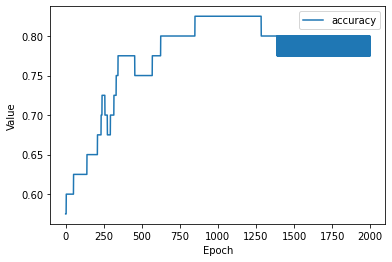

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.0007
epochs = 2000
batch_size = 40
label_name = "value_good"
classification_threshold = 0.5

# Establish the metrics the model will measure.
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),tf.keras.metrics.Precision(thresholds=classification_threshold, name='precision'), tf.keras.metrics.Recall(thresholds=classification_threshold, name="recall")]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, label_name, batch_size)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)

In [ ]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size = 10)

1/1 [==============================] - 0s 352ms/step - loss: 0.7486 - accuracy: 0.5000 - precision: 0.5714 - recall: 0.6667


[0.7485915422439575, 0.5, 0.5714285969734192, 0.6666666865348816]

# Testing

In [ ]:
os.chdir("/content/drive/MyDrive/Lobot/CSVs/")

with open("LiquidSwords.csv", "w") as f:
    f.writelines(csv_string)

In [ ]:
midi_df2 = pd.read_csv("ElectricRelaxation.csv")

In [ ]:
print(midi_df)
print(midi_df2)

       0      0        Header       0.1     1    43
0      1      0   Start_track       NaN   NaN   NaN
1      1      0         Tempo  500000.0   NaN   NaN
2      1      0     Program_c       0.0   0.0   NaN
3      1      0     Note_on_c       0.0  48.0  52.0
4      1      4    Note_off_c       0.0  48.0  64.0
...   ..    ...           ...       ...   ...   ...
26234  1  18741    Note_off_c       0.0  40.0  64.0
26235  1  18745     Note_on_c       0.0  42.0  25.0
26236  1  18749    Note_off_c       0.0  42.0  64.0
26237  1  18749     End_track       NaN   NaN   NaN
26238  0      0   End_of_file       NaN   NaN   NaN

[26239 rows x 6 columns]
       0      0        Header       0.1     1    43
0      1      0   Start_track       NaN   NaN   NaN
1      1      0         Tempo  500000.0   NaN   NaN
2      1      0     Program_c       0.0   0.0   NaN
3      1      0     Note_on_c       0.0  48.0  52.0
4      1      4    Note_off_c       0.0  48.0  64.0
...   ..    ...           ...       ..

In [ ]:
csv_string = ['0, 0, Header, 1, 2, 480\n', '1, 0, Start_track\n','1, 0, Title_t, "Close Encounters"\n','1, 0, Text_t, "Sample for MIDIcsv Distribution"\n','1, 0, Copyright_t, "This file is in the public domain"\n','1, 0, Time_signature, 4, 2, 24, 8\n','1, 0, Tempo, 500000\n','1, 0, End_track\n','2, 0, Start_track\n','2, 0, Instrument_name_t, "Church Organ"\n',
              '2, 0, Program_c, 1, 29\n',
              '2, 0, Note_on_c, 1, 20, 79\n',
              '2, 0, Note_on_c, 1, 40, 127\n',
              '2, 1600, Note_off_c, 1, 20, 20\n',
              '2, 1600, Note_on_c, 1, 81, 81\n',
              '2, 1920, Note_off_c, 1, 81, 0\n',
              '2, 1920, Note_on_c, 1, 77, 81\n',
              '2, 2880, Note_off_c, 1, 77, 0\n',
              '2, 2880, Note_on_c, 1, 65, 81\n',
              '2, 3840, Note_off_c, 1, 65, 0\n',
              '2, 3840, Note_on_c, 1, 72, 81\n',
              '2, 3840, Note_off_c, 1, 40, 0\n',
              '2, 4800, Note_off_c, 1, 72, 0\n',
              '2, 4800, End_track\n',
              '0, 0, End_of_file\n']

In [ ]:
midi_object = pm.csv_to_midi(csv_string)

In [ ]:
os.chdir("/content/drive/MyDrive/Lobot/MIDI_Files/")

with open("example_converted.mid", "wb") as output_file:
    midi_writer = pm.FileWriter(output_file)
    midi_writer.write(midi_object)

## Further Data Extraction

## Time

In [ ]:
def time(Notes):

  return Notes[-1].start

In [ ]:
length = len(Big_Notes)

times = []

for i in range(length):

  times.append(time(Big_Notes[i]))

In [ ]:
print(times)

[8972.0, 12664.0, 8723.0]


## Average Note Length

In [ ]:
def avg_l(Notes):

  size = len(Notes)

  sum = 0

  for i in range(size):

    sum += Notes[i].length

  return sum / size

In [ ]:
avg_ls = []

for i in range(len(Big_Notes)):

  avg_ls.append(avg_l(Big_Notes[i]))

In [ ]:
print(avg_ls)

[4.811230445949101, 3.948405961139408, 4.491998171010517]


## Average Pitch

In [ ]:
def avg_p(Notes):

  length = len(Notes)

  sum = 0

  for i in range(length):

    sum += Notes[i].length * Notes[i].pitch

  return sum / (length * avg_l(Notes))

In [ ]:
avg_ps = []

for i in range(len(Big_Notes)):

  avg_ps.append(avg_p(Big_Notes[i]))

In [ ]:
print(avg_ps)

[70.64004076383665, 76.72351353288263, 65.78433767643865]


## Average Note Repitition and Unique Notes

In [ ]:
def avg_r_unq(Notes):

  pitchs = {}
  sum = 0
  count = 0

  for i in range(len(Notes)):

    curr_p = Notes[i].pitch

    if curr_p in pitchs:

      pitchs[curr_p] += 1

    else:

      pitchs[curr_p] = 1

  for pitch in pitchs:

    sum += pitchs[pitch]
    count += 1
  
  return [sum / count, count]

In [ ]:
avg_rs = []
unqs = []

for i in range(len(Big_Notes)):

  temp = avg_r_unq(Big_Notes[i])

  avg_rs.append(temp[0])

  unqs.append(temp[1])

In [ ]:
print(avg_rs)
print(unqs)

[108.43037974683544, 121.86206896551724, 88.66216216216216]
[79, 87, 74]


## Average Note Saturation

In [ ]:
def avg_s(Notes):

  reps = []
  starts = {}
  sum = 0
  count = 0

  for i in range(len(Notes)):

    curr_s = Notes[i].start

    if curr_s in starts:

      starts[curr_s] += 1

    else:

      starts[curr_s] = 1

  for start in starts:

    sum += starts[start]
    count += 1
  
  return sum / count

In [ ]:
avg_ss = []

for i in range(len(Big_Notes)):

  avg_ss.append(avg_s(Big_Notes[i]))

In [ ]:
print(avg_ss)

[2.2625462229265714, 1.8711613130956584, 1.5951859956236323]


## Music Gini

In [ ]:
def gini(Notes):

  pitchs = {}
  sum = 0
  count = 0
  total = len(Notes)
  curr = 0

  for i in range(total):

    curr_p = Notes[i].pitch

    if curr_p in pitchs:

      pitchs[curr_p] += 1

    else:

      pitchs[curr_p] = 1

  pitchs = dict(sorted(pitchs.items(), key=lambda item: item[1]))

  per_pitch = 1 / len(pitchs)

  num_pitchs = 1 / per_pitch

  for pitch in pitchs:

    curr += 1

    greater = (num_pitchs - curr) / num_pitchs

    temp = pitchs[pitch] / total

    sum +=  temp * (per_pitch + 2 * greater)

  
  return 1 - sum

In [ ]:
ginis = []

for i in range(len(Big_Notes)):

  ginis.append(gini(Big_Notes[i]))

In [ ]:
print(ginis)

[0.49792674601087017, 0.4612836007953388, 0.4302388808561649]
